In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import tensorflow as tf

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from matplotlib import pyplot as plt
%matplotlib inline

# imports from our libreries
import sampling as sp
from datasets import spirals
from utils import define_loss
from utils import LambdaParameter
from models import FeedForwardModel
from sequential_copy import sequential_train

## 1. Create original problem

#### 1.1 Create original dataset

In [9]:
# Create new problem
#X, y = make_moons(**{'n_samples':1500, 'shuffle':True, 'noise':0.2, 'random_state':42})
X, y = spirals(1500)
X = StandardScaler(copy=True).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=7)

#### 1.2 Train original model

In [14]:
# Fit model
original = SVC(random_state=42, kernel='rbf', probability=True, gamma=10)
original.fit(X_train, y_train)

y_test_pred = original.predict(X_test)
acc = np.average(np.where(y_test_pred==y_test,1.,0.))
print('A0:', acc)

A0: 1.0


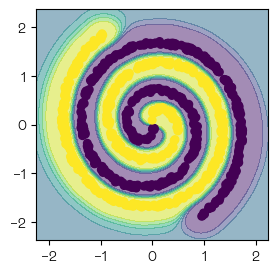

In [15]:
# Define domain
min_, max_ = np.min(X_train-0.5, axis=0), np.max(X_train+0.5, axis=0)
xx, yy = np.meshgrid(np.arange(min_[0], max_[0], .025), np.arange(min_[1], max_[1], .025))
z = original.predict_proba(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))[:,0].reshape(xx.shape)

# Initialize figure
fig = plt.figure(figsize=(3,3)) 
ax = fig.add_subplot(111)
ax.contourf(xx, yy, z, alpha=0.5)
plot = ax.scatter(X_test[:,0], X_test[:,1], c=-y_test, s=30)

## 2. Train single copy model

In [ ]:
# setting initial parameters

d = X_test.shape[1]
n_classes = len(np.unique(y_test))

lr = 0.0005
layers = [64,32,10]
lmda = 0.0
automatic_lmda = False
n_samples_iter=100
max_iter=10
thres=1e-9
sample_selection=False

#### 2.1 Instantiate copy model

In [17]:
# define optimizer and loss 
opt = tf.keras.optimizers.Adam(learning_rate=lr)
loss = define_loss(d, loss_name = 'UncertaintyError')

# define new model
seq_copy = FeedForwardModel(input_dim=d, hidden_layers=layers, output_dim=n_classes, activation='relu')
seq_copy.build(input_shape=(layers[0],d))
seq_copy.compile(loss=loss, optimizer=opt)

# define the memory (lambda) parameter
lmda_ = LambdaParameter(lmda=lmda, automatic_lmda=automatic_lmda)

#define the sampling process
sampler = sp.Sampler(d=d, n_classes=n_classes)

#### 2.2 Sequential train

In [18]:
# fit copy model
trained_model = sequential_train(seq_copy, 
                                 sampler, 
                                 original, 
                                 n_samples_iter=n_samples_iter,
                                 thres=thres, 
                                 lmda_par = lmda_,
                                 max_iter=max_iter, 
                                 X_test=X_test, 
                                 y_test=y_test, 
                                 sample_selection=sample_selection,
                                 plot_every=False)

In [19]:
print(trained_model.acc_test)
print(trained_model.n)
print(trained_model.acc_train)
print(trained_model.rho)
print(trained_model.lmda_vector)

ListWrapper([0.59, 0.7766666666666666, 0.8188888888888889, 0.8777777777777778, 0.9577777777777777, 1.0, 1.0, 1.0, 1.0, 1.0])
ListWrapper([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
ListWrapper([0.93, 0.935, 0.9266666666666666, 0.94, 0.948, 0.9916666666666667, 0.9942857142857143, 0.99625, 0.99, 0.998])
ListWrapper([0.049675234391062195, 0.06619958882039902, 0.07268132791538245, 0.060048889758294734, 0.04841660474303302, 0.007717884647148946, 0.004822703764430885, 0.0037607116344181377, 0.008613285770013966, 0.0020129908344920493])
ListWrapper([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


#### 2.3 Plot results

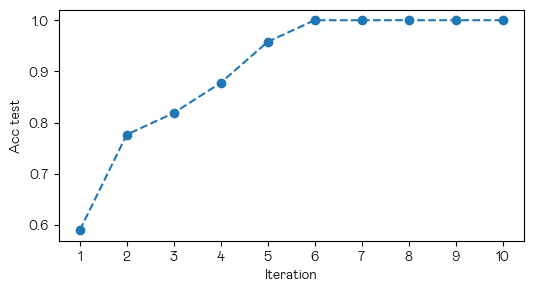

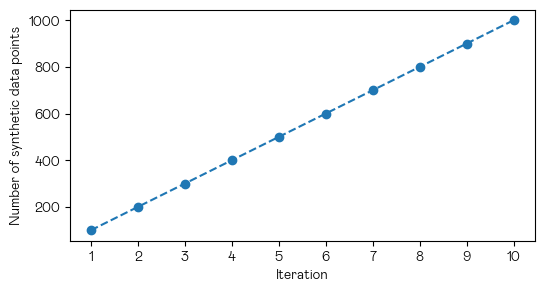

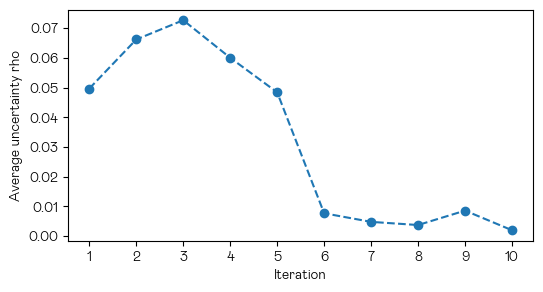

In [108]:
plot_results(trained_model, plot_type='acc_test')
plot_results(trained_model, plot_type='nN')
plot_results(trained_model, plot_type='rho')

## 3. Train multiple copy models in parallel

In [105]:
from joblib import Parallel, delayed

def separate_runs(original,
                  lr=0.0005,
                  n_samples_iter=100, 
                  thres=1e-9, 
                  lmda_par = 0.0,
                  max_iter=3, 
                  X_test=None, 
                  y_test=None, 
                  layers = [64,32,10],
                  sample_selection=True):
    
    d = X_test.shape[1]
    n_classes = len(np.unique(y_test))
    
    # define optimizer and loss 
    opt_ = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_ = define_loss(d, loss_name = 'UncertaintyError')

    # define new model
    seq_copy_ = FeedForwardModel(input_dim=d, hidden_layers=layers, output_dim=n_classes, activation='relu')
    seq_copy_.build(input_shape=(layers[0],d))
    seq_copy_.compile(loss=loss_, optimizer=opt_)

    # define the memory (lambda) parameter
    lmda_ = LambdaParameter(lmda=lmda_par, automatic_lmda=False)

    #define the sampling process
    sampler_ = sp.Sampler(d=d, n_classes=n_classes)
    
    return sequential_train(seq_copy_, 
                            sampler_, 
                            original, 
                            n_samples_iter=n_samples_iter, 
                            thres=thres, 
                            lmda_par =lmda_,
                            max_iter=max_iter, 
                            X_test=X_test, 
                            y_test=y_test, 
                            sample_selection=sample_selection,
                            plot_every=False)

def plot_results(model, plot_type='acc_test'):
    fig = plt.figure(figsize=(6,3)) 
    ax = fig.add_subplot(111)    
    ax.set_xlabel('Iteration')
    x = np.arange(1, len(trained_model.acc_test)+1)
    ax.set_xticks(np.arange(1, len(trained_model.acc_test)+1))
    
    if plot_type == 'acc_test':
        plt.plot(x, trained_model.acc_test,'o--')
        ax.set_ylabel('Acc test')
    elif plot_type == 'nN':
        plt.plot(x, trained_model.n,'o--')
        ax.set_ylabel('Number of synthetic data points')
    elif plot_type == 'rho':
        plt.plot(x, trained_model.rho,'o--')
        ax.set_ylabel('Average uncertainty rho')
    else:
        pass
    
    plt.show()

In [95]:
n_runs = 5
results = Parallel(n_jobs=-1, backend='threading')(delayed(separate_runs)(original,
                                                                          lmda_par=0.1, 
                                                                          n_samples_iter=50,
                                                                          X_test=X_test, 
                                                                          y_test=y_test
                                           )  for i in range(0, n_runs))

In [96]:
def decode_results(data):
    n, acc_train, acc_test, rho, lmda = ([] for i in range(5))
    
    for i in range(len(data)):
        n.append(list(data[i].n))
        acc_train.append(list(data[i].acc_train))
        acc_test.append(list(data[i].acc_test))
        rho.append(list(data[i].rho))
        lmda.append(list(data[i].lmda_vector))
        
    return np.array(n), np.array(acc_train), np.array(acc_test), np.array(rho), np.array(lmda)

In [102]:
n, acc_train, acc_test, rho, lmda_vector = decode_results(results)

## 4. Plots

In [101]:
##### ------- DUMMY RESULTS PARA NO TENER QUE CORRER EL CODIGO CADA VEZ
n, acc_train, acc_test, rho, lmda_vector = (np.array([[ 50,  77, 109],
        [ 50,  82, 109],
        [ 50,  82, 102]]),
 np.array([[1.        , 1.        , 1.        ],
        [1.        , 1.        , 0.99082569],
        [1.        , 1.        , 0.94117647]]),
 np.array([[0.59888889, 0.67888889, 0.84      ],
        [0.55      , 0.68444444, 0.70333333],
        [0.61666667, 0.77      , 0.73444444]]),
 np.array([[0.0026422 , 0.00051347, 0.00017135],
        [0.00169434, 0.01192237, 0.01056969],
        [0.00071333, 0.00048053, 0.05901857]]),
 np.array([[0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1]]))

one_shot = np.array([[0.72, 0.75, 0.73], [0.79, 0.786, 0.775], [0.82, 0.85, 0.843]])

online_single = np.array([[0.59888889, 0.623339, 0.65444      ],
        [0.55      , 0.601, 0.63222],
        [0.61666667, 0.61556      , 0.64]])

acc_delta_1 = np.array([[0.58, 0.65, 0.75    ],
        [0.55      , 0.66, 0.77],
        [0.61, 0.64      , 0.76]])

acc_delta_2 = np.array([[0.59, 0.64, 0.73      ],
        [0.56      , 0.63, 0.73],
        [0.60, 0.63      , 0.71]])

acc_delta_3 = np.array([[0.56, 0.62, 0.68888     ],
        [0.58      , 0.61, 0.69443],
        [0.57, 0.625      , 0.676565]])

n_delta_1 = np.array([[50, 75, 105],
        [50      , 76, 106],
        [50, 72   , 106]])

n_delta_2 = np.array([[50, 77,109  ],
        [50      , 78, 110],
        [50, 82, 111]])

n_delta_3 = np.array([[50, 89, 114],
        [50      , 76,113],
        [50, 84   , 110]])

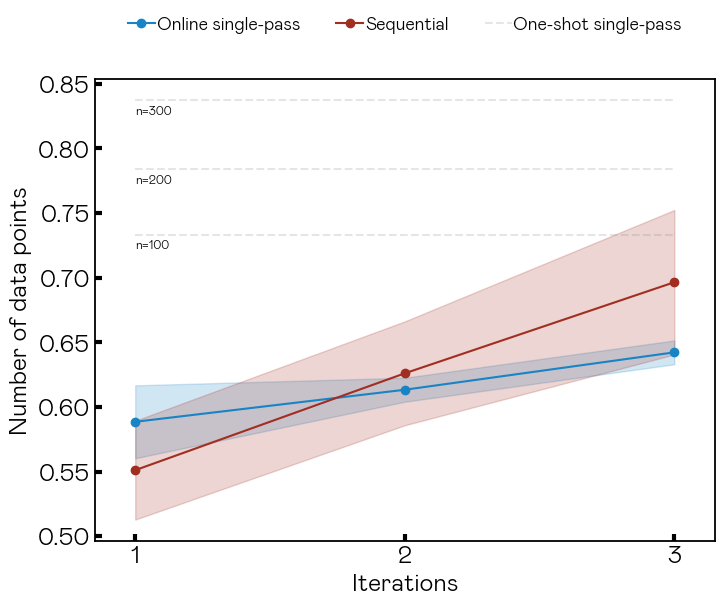

In [103]:
from plots import iteration_plot

iteration_plot([online_single, acc_test], 
               ['Online single-pass', 'Sequential'],
               ylabel='Number of data points',
               fill=True, 
               single_pass=True,
               one_shot=one_shot)

In [99]:
iteration_plot([online_single, acc_test, acc_delta_1, acc_delta_2, acc_delta_3], 
               labels=['Online single-pass', 'Pure sequential', r'$\delta = 10^{-6}$',r'$\delta = 10^{-8}$',r'$\delta = 10^{-10}$'],
               ylabel='Accuracy',
               single_pass=True,
               fill=True)

NameError: name 'online_single' is not defined

In [10]:
####---- MODIFICAR DE AQUÑI HACIA ABAJO PARA LOS PLOTS DE COMAPRACIÓN ENTRE BEST RESULTS ACCURACY, EFFICIENCY, CONVERGENCE

In [ ]:
def scatter_both_metrics(vec1,vec2, n1=0, n2=1,N=50, text = False, histo=False, label_bool = False, xlabel = 'Efficiency', ylabel= r'$AUC_{acc}$', color=['tab:blue','tab:orange','tab:red'],l1='',l2='',l3=''):
    ## n=0 eff
    ## n=1 conv
    ## n=2 acc
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    dist_vec = []
    
    for i in range(len(vec1)):
        if vec1[i][3]==vec2[i][3]:
            dist, m = distance([vec1[i][n1],vec1[i][n2]],[vec2[i][n1],vec2[i][n2]])
            dist_vec.append(dist)
            if dist != 0.0:
                ax.plot([vec2[i][n1],vec1[i][n1]], [vec2[i][n2],vec1[i][n2]],'--' ,c='grey', linewidth=2, alpha=0.2, zorder=-50)
                if text:
                    ax.text((vec2[i][n1]+vec1[i][n1])/2, (vec2[i][n2]+vec1[i][n2])/2, s = str(round(m,2)), fontsize=7)
                if ylabel == 'Convergence':
                    m1 = ax.scatter(vec1[i][n1],vec1[i][n2], c=color[0], marker = '*', s=120, label=l1)
                else:
                    m1 = ax.scatter(vec1[i][n1],vec1[i][n2], c=color[0], marker = 'o', s=120, label=l1)
                if xlabel == 'Convergence':
                    m2 = ax.scatter(vec2[i][n1],vec2[i][n2], c=color[1], marker = '*', s=120, label=l2)
                else:
                    m2 = ax.scatter(vec2[i][n1],vec2[i][n2], c=color[1], marker = ',', s=120, label=l2)
            else:
                m3 = ax.scatter(vec1[i][n1],vec1[i][n2], c=color[2], marker= 'v', s=120, label=l3)
    
    if histo:
        fig2 = plt.figure(figsize=(8,6))
        ax2 = fig2.add_subplot(111)
        ax2.hist(dist_vec)
    
    
    ax.set_ylabel(ylabel)    
    ax.set_xlabel(xlabel)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
        
    plt.rcParams['font.size'] = '22'
    wd = 3
    lt = 5
    ax.xaxis.set_tick_params(width=wd,length = lt)
    ax.yaxis.set_tick_params(width=wd,length = lt)
    ax.tick_params(axis='both',direction="in",which='major', labelsize=22)
    ax.tick_params(axis='both', labelsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    
    if ylabel == 'Accuracy':
        ax.set_ylim([0.39, 1.01])
        ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
    if xlabel == 'Efficiency':
        ax.set_xlim([0.09, 1.01])
        ax.set_xticks([0.1,0.25,0.4,0.55,0.7, 0.85,1])
    if ylabel == 'Efficiency':
        ax.set_ylim([0.09, 1.01])
        ax.set_yticks([0.1,0.25,0.4,0.55,0.7, 0.85,1])
    if xlabel == 'Convergence':
        ax.set_xlim([0.069, 1.01])
        ax.set_xticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
    if ylabel == 'Convergence':
        ax.set_ylim([0.069, 1.01])
        ax.set_yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
    #ax.set_xlim(0.5,1)
    #ax.set_ylim(0.45,1)
    
    if label_bool:
        #plt.legend(handles=[m1,m2,m3],bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3, shadow=True,fontsize = 15,handletextpad=0.1)   
        plt.legend(handles=[m1,m2,m3], bbox_to_anchor=(0, 0.9, 1, 0.2), 
                  loc="upper center",
                  borderaxespad=0,
                  frameon=False,
                  ncol=3, 
                  handlelength=1.5,
                  shadow=False,
                  fontsize = 13,
                  handletextpad=0.1)
    return fig


In [ ]:
def distance(p1,p2):
    dist = np.sqrt( (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    if dist != 0.0:
        m =  (p1[1]-p2[1])/(p1[0]-p2[0])
        return dist, m
    else:
        return dist, 0.0

In [75]:
from scipy import integrate

def simpson_integration(x,y):
    return integrate.simpson(y, x)

def get_all_auc(data):
    max_iter = data.shape[1]
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    max_acc = mean.max() # max accuracy over iterations (not over runs!)
    max_std = std.max()
    x = range(1, max_iter+1) # range of number of iterations
    acc_simp = simpson_integration(x, mean)/max_iter
    acc_err = ((simpson_integration(x, mean+std)/max_iter) - (simpson_integration(x, mean-std)/max_iter))*0.5
    
    return max_acc, acc_simp, max_std, acc_err

def normalize_acc_curve(acc, auc, auc_std):
    # para el caso del accuracy hay que normalizar (se hace sobre todos los frames)
    acc_ = max(acc)
    return list(np.array(auc)/acc_), list(np.array(auc_std)/acc_)

# ESTO SE HACE PARA LOS VALORS DE Nn  Y PARA LOS DE ACCURACY
# UNA VEZ PARA CADA UNO (get_all_auc)

# esto se hace frame a frame, que entiendo que es setting a setting de parametros
# la N (n_samples_iter) está fija y los frames se refieren a los distintos valores de delta (el THRESH)
# el primero siempre es el single, el index 0, por eso más abajo normalizar por este valor el acc

def get_performance_metrics(settings, plot_type='acc'):

    max_acc, auc, max_acc_std, auc_std = ([] for i in range(4))

    for setting in settings:

        _acc, _auc, _acc_std, _auc_std = get_all_auc(setting)

        max_acc.append(_acc)
        auc.append(_auc)
        max_acc_std.append(_acc_std)
        auc_std.append(_auc_std)

    if plot_type== 'acc':
        auc, auc_std = normalize_acc_curve(acc, auc, auc_std)
        
    return max_acc, auc, max_acc_std, auc_std

def compute_metrics(a, b, c):
    a = [x for _, x in sorted(zip(b, a), reverse = True)]
    c = [x for _, x in sorted(zip(b, c), reverse = True)]
    if len(std)>0:
        a_std = [x for _, x in sorted(zip(b, a_std), reverse = True)]
        c_std = [x for _, x in sorted(zip(b, c_std), reverse = True)]
        b_std = [x for _, x in sorted(zip(b, b_std), reverse = True)]
    a = sorted(a, reverse = True) 
    return [c[0],b[0], a[0], c_std[:1], b_std[:1], a_std[:1]]

In [88]:
acc_settings = [acc_test, acc_delta_1, acc_delta_2, acc_delta_3]
n_settings = [n, n_delta_1, n_delta_2, n_delta_3]
settings = ['plain', 'delta_1', 'delta_2', 'delta_3']

acc_max_acc, acc_auc, acc_max_acc_std, acc_auc_std = get_performance_metrics(acc_settings, plot_type='acc')
n_max_acc, n_auc, n_max_acc_std, n_auc_std = get_performance_metrics(n_settings, plot_type='n')

In [ ]:
# HAY QUE HACER LO MISMO PARA EL SINGLE. TAL VEZ SEA NECESARIO CAMBAR ALGO EN LA FUNCIÓN get_all_auc

In [ ]:
acc_comparation_vec.append([max_acc[0],np.max(max_acc[1:]), dataset])
auc_acc_vec.append(auc_acc)
efficiency =[1-l for l in n_auc]

In [ ]:
acc_thres = 0.95
acc_auc = acc_auc[acc_max_acc > = (acc_max_acc_single*acc_thresh)]
eff = eff[acc_max_acc>=(acc_max_acc_single*acc_thresh)]

# modificar el valor del threshold si no hay puntos
while (len(acc_auc)) == 0 or (len(eff) == 0):
    acc_thres = acc_thresh*0.99
    acc_auc = acc_auc[acc_max_acc > = (acc_max_acc_single*acc_thresh)]
    eff = eff[acc_max_acc>=(acc_max_acc_single*acc_thresh)]

if len(acc_auc_std)>0:
    acc_auc_std = acc_auc_std[acc_max_acc>=(acc_max_acc_single*acc_thresh)]
    eff_std = eff_std[acc_max_acc>=(acc_max_acc_single*acc_thresh)]
    acc_max_acc_std = acc_max_acc_std[acc_max_acc>=(acc_max_acc_single*acc_thresh)]
acc_max_acc = acc_max_acc[acc_max_acc>=(acc_max_acc_single*acc_thresh)]

max_acc_result = compute_metrics(acc_auc, acc_max_acc, efficiency)
max_eff_result = compute_metrics(acc_auc, efficiency, acc_max_acc)
max_conv_result = compute_metrics(efficiency, acc_auc, acc_max_acc)

In [ ]:
max_vec = []
eff_vec = []
conv_vec = []

colors = ['#a12e21','#a12e21','#a12e21']

datasets = ['spirals','yinyang','moons']#,'mammographic']
# datasets = ['miniboone','breast-cancer-wisc-prog','synthetic-control']
#datasets = [l for l in dic_datasets]
#datasets = ['spirals']
N_vec = [100]#,100]

lpos = 'out'
xrange = -1 
plot_dataset_summary = False
acc_comparation_vec = []


for dataset in datasets:
    date = dic_datasets[dataset]
    auc_acc_vec = []
    auc_nN_vec = []
    acc_max_vec = []
    
    for nN in N_vec:

        selected_paths ,labels = pltf.sorted_paths_and_labels(dataset=dataset,nN=nN,date=date)

        auc_acc, max_acc, auc_nN  = pltf.get_all_auc(selected_paths=selected_paths,nN=nN,dataset=dataset)
        acc_comparation_vec.append([max_acc[0],np.max(max_acc[1:]), dataset])

        auc_acc_vec.append(auc_acc)
        efficiency =[1-l for l in auc_nN]
        auc_nN_vec.append(efficiency)

        #max_acc_metric_point, max_eff_metric_point = pltf.metrics_data(auc_acc,auc_nN,max_acc,dataset,nN)
        max_acc_metric_point, max_eff_metric_point, max_conv_metric_point = pltf.metrics_data(
                                                                                auc_acc,efficiency,max_acc,dataset,nN)

        max_vec.append(max_acc_metric_point)
        eff_vec.append(max_eff_metric_point)
        conv_vec.append(max_conv_metric_point)

        acc_max_vec.append(max_acc)

        filenames = ['','','']
        lpos = ['out','out','out']
        plot_types=['acc_test','nN']#,'lmda']

        print('====== '+dataset+' ======')

        if plot_dataset_summary:
            for pt,filename,lps in zip(plot_types,filenames,lpos):
                pltf.many_paths_to_1_plot(selected_paths, labels = labels, plot_type=pt,save=False,
                                          save_path='plots_paper/trash/', name = filename, lpos=lps, shade=False,
                                          xrange=xrange, single = True , dataset = dataset, single_N = nN)

        #print(max_vec,eff_vec)

        diff_nN = True
        if len(auc_nN_vec)<1:
            diff_nN = False
        if plot_dataset_summary:
            fig = pltf.plot_scatter(auc_nN_vec,
                              auc_acc_vec,
                              xlabel='Efficiency',
                              ylabel='AUC (Accuracy)',
                              title='Results for ' +dataset,
                              labels=labels,
                              lpos=lpos,
                              mk_size=120,
                              diff_nN=diff_nN,
                              N_labels=N_vec,
                              max_acc=acc_max_vec)

            ''' for spirals, figures 5
            ax = fig.get_axes()[0]
            
            ax.get_legend().remove()
            ax.set_title('')
            path = 'plots_paper/toy/'

            filenames = ['fig5.pdf']
            pltf.save_fig(fig,path,filenames[0])
            '''

In [ ]:
acc_plot = scatter_both_metrics(max_vec, eff_vec, n1=0, n2=2, N=100, 
                                     text=False, histo=False, xlabel='Efficiency', ylabel='Accuracy',
                                     color=colors,label_bool=True, l1='Best accuracy', l2='Best efficiency', l3='Same value')
ax = acc_plot.get_axes()[0]
n1=0
n2=2
i=0
ax.text(max_vec[i][n1], max_vec[i][n2]+0.003, s = max_vec[i][3], fontsize=15)
i=1
ax.text(max_vec[i][n1]-0.05, max_vec[i][n2]+0.004, s = max_vec[i][3], fontsize=15)
i=2
ax.text(max_vec[i][n1], max_vec[i][n2]+0.003, s = max_vec[i][3], fontsize=15)




path = 'plots_paper/toy/'
filename = 'toy_acc_eff(ba_be).pdf'
pltf.save_fig(acc_plot,path,filename)

In [ ]:
# input: array de acc/nn/rho/lmda vs. iteración para cada run
# output: array mean/std para cada iteración
# auc calcular std usando simpson integration

In [9]:
### ESTO DÓNDE VA?

def sampler_tester():
    ## testing generation of synthetic data
    sampler = sp.Sampler(balancer = False)
    plotting_test(sampler, n=2000, title='Balancer False')
    sampler = sp.Sampler(balancer = True)
    plotting_test(sampler, n=2000, title='Balancer True')

    ## setting parameter to read from file
    file_name = 'test4.csv' # try non existent file_name
    sampler = sp.Sampler(from_file = True) # error
    plotting_test(sampler, n=2000, title='No file set, data generated')

    sampler = sp.Sampler(from_file = True, file_path = file_name) # error, you should set automatic_fill ti True
    plotting_test(sampler, n=2000, title='File does not exist. Data generated')

    sampler = sp.Sampler(from_file = True, file_path = file_name, automatic_fill=True) # works. File created
    plotting_test(sampler, n=2000, title='From file... but, it does not has data. Data generated')
    print('File', file_name, 'has 2000 points')

    ## reading from file
    sampler = sp.Sampler(from_file = True, file_path = file_name, automatic_fill=True) # works. File created
    plotting_test(sampler, n=2000, title='From file!')

def plotting_test(sampler, n=100, title=''):
    # plotting new synthetic data from the sample generator using original model
    X,y = sampler.get_samples(original, n)
    fig = plt.figure(figsize=(3,3)) 
    ax = fig.add_subplot(111)
    plot = ax.scatter(X[:,0], X[:,1], c=-y, s=20)
    ax.set_title(title)
    plt.show()